In [1]:
# -*- coding: utf-8 -*-

"""
This program makes learning ev-gmm.
"""

'\nThis program makes learning ev-gmm.\n'

In [2]:
# __future__ module make compatible python2 and python3
from __future__ import division, print_function

# basic modules
import os
import os.path
import time

# for warning ignore
import warnings
#warning.filterwarnings('ignore')

# for file system manupulation 
from shutil import rmtree 
import glob
import argparse

# for save object
import pickle

# for make glaph
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 5)
import librosa.display

# for scientific computing
import numpy as np
from numpy.linalg import norm 
from sklearn.decomposition import PCA
from sklearn.mixture import GMM # GMM class cannot use after sklearn 0.20.0
import sklearn.mixture
#from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from sklearn.preprocessing import StandardScaler
import scipy.sparse
from scipy.signal import firwin, lfilter

# for display audio controler
from IPython.display import Audio

# for manuplate audio data
import soundfile as sf
import pyworld as pw
import pysptk
from dtw import dtw
from fastdtw import fastdtw

In [3]:
class WORLD(object):
    """
    WORLD based speech analyzer and synthezer.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    def __init__(self, fs=16000, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
        """
        Parameters
        ----------
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        minf0 : float
            Floor in F0 estimation
        maxf0 : float
            Seli in F0 estimation
        """
        
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
        self.minf0 = minf0
        self.maxf0 = maxf0
        
    def analyze(self, x):
        """
        Analyze acoustic featueres.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """
        
        f0, time_axis = pw.harvest(x, self.fs, f0_floor=self.minf0,
                                   f0_ceil=self.maxf0, frame_period=self.shiftms)
        sp = pw.cheaptrick(x, f0, time_axis, self.fs, fft_size=self.fftl)
        ap = pw.d4c(x, f0, time_axis, self.fs, fft_size=self.fftl)
        
        assert sp.shape == ap.shape
        
        return f0, sp, ap
    
    def analyze_f0(self, x):
        """
        Analyze f0.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        """

        f0, time_axis = pw.harvest(x, self.fs, f0_floor=self.minf0,
                                   f0_ceil=self.maxf0, frame_period=self.shiftms)
        
        assert f0.shape == x.shape()
        
        return f0
    
    def synthesis(self, f0, sp, ap):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """

        return pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)

In [4]:
class FeatureExtractor(object):
    """
    Analyze acoustic features from a waveform.
    
    This class may have several types of estimeter like WORLD or STRAIGHT.
    Default type is WORLD.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    
    def __init__(self, analyzer='world', fs=16000, fftl=1024, 
                 shiftms=5.0, minf0=50.0, maxf0=500.0):
        """
        Parameters
        ----------
        analyzer : str
            Analyzer
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        minf0 : float
            Floor in F0 estimation
        maxf0 : float
            Seli in F0 estimation
        """
        
        self.analyzer = analyzer
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
        self.minf0 = minf0
        self.maxf0 = maxf0
    
        if self.analyzer == 'world':
            self.analyzer = WORLD(fs=self.fs, fftl=self.fftl, 
                                  minf0=self.minf0, maxf0=self.maxf0, shiftms=self.shiftms)
        else:
            raise('Analyzer Error : not support type, see FeatureExtractor class.')
        
        self._f0 = None
        self._sp = None
        self._ap = None
        
    def analyze(self, x):
        """
        Analyze acoustic featueres.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """
        
        self.x = np.array(x, dtype=np.float)
        self._f0, self._sp, self._ap = self.analyzer.analyze(self.x)
        
        # check f0 < 0
        self._f0[self._f0 < 0] = 0
        
        if np.sum(self._f0) == 0.0:
            print("Warning : F0 values are all zero.")
        
        return self._f0, self._sp, self._ap
    
    def analyze_f0(self, x):
        """
        Analyze f0.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        """

        self.x = np.array(x, dtype=np.float)
        self._f0 = self.analyzer.analyze_f0(self.x)

        # check f0 < 0
        self._f0[self._f0 < 0] = 0
        
        if np.sum(self._f0) == 0.0:
            print("Warning : F0 values are all zero.")
        
        return self._f0
    
    def mcep(self, dim=24, alpha=0.42):
        """
        Convert mel-cepstrum sequence from spectral envelope.
        
        Parameters
        ----------
        dim : int
            mel-cepstrum dimension
        alpha : float
            parameter of all-path filter
        
        Returns
        ----------
        mcep : array, shape(`T`, `dim + 1`)
            mel-cepstrum sequence
        """        
        
        self._analyzed_check()
        
        return pysptk.sp2mc(self._sp, dim, alpha)
    
    def codeap(self):
        """
        """
        self._analyzed_check()
        
        return pw.code_aperiodicity(self._ap, self.fs)
    
    def npow(self):
        """
        Normalized power sequence from spectral envelope.
        
        Returns
        ----------
        npow : vector, shape(`T`, `1`)
            Normalized power sequence of the given waveform
        """
        
        self._analyzed_check()
        
        npow = np.apply_along_axis(self._spvec2pow, 1, self._sp)
        
        meanpow = np.mean(npow)
        npow = 10.0 * np.log10(npow / meanpow)
        
        return npow
    
    def _spvec2pow(self, specvec):
        """
        """
        fftl2 = len(specvec) - 1
        fftl = fftl2 * 2
        
        power = specvec[0] + specvec[fftl2]
        for k in range(1, fftl2):
            power += 2.0 * specvec[k]
        power /= fftl
        
        return power
        
    def _analyzed_check(self):
        if self._f0 is None and self._sp is None and self._ap is None:
            raise('Call FeatureExtractor.analyze() before this method.')

In [5]:
class Synthesizer(object):
    """
    Synthesize a waveform from acoustic features.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    def __init__(self, fs=16000, fftl=1024, shiftms=5.0):
        """
        Parameters
        ----------
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        """
        
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
    
    def synthesis(self, f0, mcep, ap, rmcep=None, alpha=0.42):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        mcep : array, shape(`T`, `dim`)
            mel-cepstrum sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        rmcep : array, shape(`T`, `dim`)
            array of reference mel-cepstrum sequence
        alpha : float
            parameter of all-path filter
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """
        
        if rmcep is not None:
            # power modification
            mcep = mod_power(mcep, rmcep, alpha=alpha)
        
        sp = pysptk.mc2sp(mcep, alpha, self.fftl)
        wav = pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)
        
        return wav
        
    def synthesis_diff(self, x, diffmcep, rmcep=None, alpha=0.42):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        filtering with a differential mel-cepstrum.
        
        Parameters
        ----------
        x : array, shape(`samples`)
            array of waveform sequence
        diffmcep : array, shape(`T`, `dim`)
            array of differential mel-cepstrum sequence
        rmcep : array, shape(`T`, `dim`)
            array of reference mel-cepstrum sequence
        alpha : float
            parameter of all-path filter
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """      
        
        x = x.astype(np.float64)
        dim = diffmcep.shape[1] - 1 
        shiftl = int(self.fs / 1000 * self.shiftms)
        
        if rmcep is not None:
            # power modification
            diffmcep = mod_power(rmcep + diffmcep, rmcep, alpha=alpha) - rmcep        
        
        # mc2b = transform mel-cepstrum to MLSA digital filter coefficients.
        b = np.apply_along_axis(pysptk.mc2b, 1, diffmcep, alpha)
        
        mlsa_fil = pysptk.synthesis.Synthesizer(pysptk.synthesis.MLSADF(dim, alpha=alpha),
                                                shiftl)
        wav = mlsa_fil.synthesis(x, b)
        
        return wav
    
    def synthesis_sp(self, f0, sp, ap):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        spc : array, shape(`T`, `dim`)
            mel-cepstrum sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """      
        
        wav = pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)
        
        return wav
    
def mod_power(cvmcep, rmcep, alpha=0.42, irlen=256):
    """
    power modification based on inpuulse responce

    Parameters
    ----------
    cvmcep : array, shape(`T`, `dim`)
        array of converted mel-cepstrum
    rmcep : arraym shape(`T`, `dim`)
        array of reference mel-cepstrum
    alpha : float
        parameter of all-path filter
    irlen : int
        Length for IIR filter

    Returns
    ----------
    modified_cvmcep : array, shape(`T`, `dim`)
        array of power modified converted mel-cepstrum
    """

    if rmcep.shape != cvmcep.shape:
        raise ValueError(
            "The shape of the converted and reference mel-cepstrum are different : {} / {}.format(cvmcep.shape, rmcep.shape)"
        )

    # mc2e = Compute energy from mel-cepstrum. e-option
    cv_e = pysptk.mc2e(cvmcep, alpha=alpha, irlen=irlen)
    r_e = pysptk.mc2e(rmcep, alpha=alpha, irlen=irlen)

    dpow = np.log(r_e / cv_e) / 2

    modified_cvmcep = np.copy(cvmcep)
    modified_cvmcep[:, 0] += dpow

    return modified_cvmcep

In [6]:
# def util methods
def melcd(array1, array2):
    """
    calculate mel-cepstrum distortion
    
    Parameters
    ----------
    array1, array2 : array, shape(`T`, `dim`) or shape(`dim`)
        Array of original and target.
    
    Returns
    ----------
    mcd : scala, number > 0
        Scala of mel-cepstrum distoriton
    """
    if array1.shape != array2.shape:
        raise ValueError(
            "The shape of both array are different : {} / {}.format(array1.shape,array2.shape)"
        )    
   
    if array1.ndim == 2:
        diff = array1 - array2
        mcd = 10.0 / np.log(10) * np.mean(np.sqrt(2.0 * np.sum(diff ** 2, axis=1)))
    elif array1.ndim == 1:
        diff = array1 - array2
        mcd = 10.0 / np.log(10) * np.sqrt(2.0 * np.sum(diff ** 2))
    else:
        raise ValueError("Dimension mismatch.")
        
    return mcd

def delta(data, win=[-1.0, 1.0, 0]):
    """
    calculate delta component
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        Array of static matrix sequence.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    delta : array, shape(`T`, `dim`)
        Array of delta matrix sequence.
    """
    
    if data.ndim == 1:
        # change vector into 1d-array
        T = len(data)
        dim = data.ndim
        data = data.reshape(T, dim)
    else:
        T, dim = data.shape
    
    win = np.array(win, dtype=np.float64)
    delta = np.zeros((T, dim))
    
    delta[0] = win[0] * data[0] + win[1] * data[1]
    delta[-1] = win[0] * data[-2] + win[1] * data[-1]
    
    for i in range(len(win)):
        delta[1:T - 1] += win[i] * delta[i:T - 2 + i]
    
    return delta

def static_delta(data, win=[-1.0, 1.0, 0]):
    """
    calculate static and delta component
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        Array of static matrix sequence.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    sddata : array, shape(`T`, `dim * 2`)
        Array of static and delta matrix sequence.
    """
    
    sddata = np.c_[data, delta(data, win)]
    
    assert sddata.shape[1] == data.shape[1] * 2
    
    return sddata

def construct_static_and_delta_matrix(T, D, win=[-1.0, 1.0, 0]):
    """
    calculate static and delta transformation matrix
    
    Parameters
    ----------
    T : scala, `T`
        Scala of time length
    D : scala, `D`
        Scala of the number of dimension.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    W : array, shape(`2 * D * T`, `D * T`)
        Array of static and delta transformation matrix.
    """
    
    static = [0, 1, 0]
    delta = win
    assert len(static) == len(delta)
    
    # generate full W
    DT = D * T
    ones = np.ones(DT)
    row = np.arange(2 * DT).reshape(2 * T, D) # generate serial numbers
    static_row = row[::2] # [1,2,3,4,5] => [1,3,5]
    delta_row = row[1::2] # [1,2,3,4,5] => [2,4]
    col = np.arange(DT)
    
    data = np.array([ones * static[0], ones * static[1],
                      ones * static[2], ones * delta[0],
                      ones * delta[1], ones * delta[2]]).flatten()
    row = np.array([[static_row] * 3, [delta_row] * 3]).flatten()
    col = np.array([[col - D, col, col + D] * 2]).flatten()

    # remove component at first and end frame
    valid_idx = np.logical_not(np.logical_or(col < 0, col >= DT))
    
    W = scipy.sparse.csr_matrix(
        (data[valid_idx], (row[valid_idx], col[valid_idx])), shape=(2 * DT, DT))
    W.eliminate_zeros()
    
    return W
    
def extfrm(data, npow, power_threshold=-20):
    """
    Extract frame over the power threshold
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        array of input data
    npow : array, shape(`T`)
        vector of normalized power sequence
    threshold : scala
        scala of power threshold [dB]
        
    Returns
    ----------
    data : array, shape(`T_ext`, `dim`)
        remaining data after extracting frame
        `T_ext` <= `T`
    """
    T = data.shape[0]
    if T != len(npow):
        raise("Length of two vectors is different.")
        
    valid_index = np.where(npow > power_threshold)
    extdata = data[valid_index]
    assert extdata.shape[0] <= T
    
    return extdata

def estimate_twf(orgdata, tardata, distance='melcd', fast=True, otflag=None):
    """
    time warping function estimator
    
    Parameters
    ----------
    orgdata : array, shape(`T_org`, `dim`)
        array of source feature
    tardata : array, shape(`T_tar`, `dim`)
        array of target feature
    distance : str 
        distance function
    fast : bool
        use fastdtw instead of dtw
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length   
    
    Returns
    ----------
    twf : array, shape(`2`, `T`)
        time warping function between original and target
    """
    
    if distance == 'melcd':
        def distance_func(x, y): return melcd(x, y)
    else:
        raise ValueError('this distance method is not support.')
    
    if fast:
        _, path = fastdtw(orgdata, tardata, dist=distance_func)
        twf = np.array(path).T
    else:
        _, _, _, twf = dtw(orgdata, tardata, distance_func) 
        
    if otflag is not None:
        twf = modify_twf(twf, otflag=otflag)
    
    return twf

def align_data(org_data, tar_data, twf):
    """
    get aligned joint feature vector
    
    Parameters
    ----------
    org_data : array, shape(`T_org`, `dim_org`)
        Acoustic feature vector of original speaker
    tar_data : array, shape(`T_tar`, `dim_tar`)
        Acoustic feature vector of target speaker
    twf : array, shape(`2`, `T`)
        time warping function between original and target
        
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim_org + dim_tar`)
        Joint feature vector between source and target
    """
    
    jdata = np.c_[org_data[twf[0]], tar_data[twf[1]]]
    return jdata

def modify_twf(twf, otflag=None):
    """
    align specified length
    
    Parameters
    ----------
    twf : array, shape(`2`, `T`)
        time warping function between original and target
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length   
    
    Returns
    ----------
    mod_twf : array, shape(`2`, `T_new`)
        time warping function of modified alignment
    """
    
    if otflag == 'org':
        of, indice = np.unique(twf[0], return_index=True)
        mod_twf = np.c_[of, twf[1][indice]].T
    elif otflag == 'tar':
        tf, indice = np.unique(twf[1], return_index=True)
        mod_twf = np.c_[twf[0][indice], tf].T 
    
    return mod_twf

def low_cut_filter(x, fs, cutoff=70):
    """
    low cut filter
    
    Parameters
    ----------
    x : array, shape('samples')
        waveform sequence
    fs : array, int
        Sampling frequency
    cutoff : float
        cutoff frequency of low cut filter
    
    Returns
    ----------
    lct_x : array, shape('samples')
        Low cut filtered waveform sequence
    """
    
    nyquist = fs // 2
    norm_cutoff = cutoff / nyquist
    
    # low cut filter
    fil = firwin(255, norm_cutoff, pass_zero=False)
    lct_x = lfilter(fil, 1, x)
    
    return lct_x

def extsddata(data, npow, power_threshold=-20):
    """
    get power extract static and delta feature vector
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        acoustic feature vector
    npow : array, shape(`T`)
        normalized power vector
    power_threshold : float
        power threshold
    
    Returns
    ----------
    extsddata : array, shape(`T_new`, `dim * 2`)
        silence remove static and delta feature vector
    """
    
    extsddata = extfrm(static_delta(data), npow, power_threshold=power_threshold)
    return extsddata

def transform_jnt(array_list):
    num_files = len(array_list)
    for i in range(num_files):
        if i == 0:
            jnt = array_list[i]
        else:
            jnt = np.r_[jnt, array_list[i]]
    return jnt
    

In [7]:
class F0statistics(object):
    """
    Estimate F0 statistics and convert F0
    """
    def __init__(self):
        pass
    
    def estimate(self, f0list):
        """
        estimate F0 statistics from list of f0
        
        Parameters
        ----------
        f0list : list, shape(`f0num`)
            List of several F0 sequence
        
        Returns
        ----------
        f0stats : array, shape(`[mean, std]`)
            values of mean and standard deviation for log f0
        """
        
        n_files = len(f0list)
        assert n_files != 0
        for i in range(n_files):
            f0 = f0list[i]
            nonzero_indices = np.nonzero(f0)
            if i == 0:
                f0s = np.log(f0[nonzero_indices])
            else:
                f0s = np.r_[f0s, np.log(f0[nonzero_indices])]
        
        f0stats = np.array([np.mean(f0s), np.std(f0s)])
        
        return f0stats

    def convert(self, f0, orgf0stats, tarf0stats):
        """
        convert F0 based on F0 statistics
        
        Parameters
        ----------
        f0 : array, shape(`T`, `1`)
            array of F0 sequence
        orgf0stats : array, shape(`[mean, std]`)
            vectors of mean and standard deviation of log f0 for original speaker
        tarf0stats : array, shape(`[mean, std]`)
            vectors of mean and standard deviation of log f0 for target speaker
        
        Returns
        ----------
        cvf0 : array, shape(`T`, `1`)
            array of converted F0 sequence
        """
        
        # get length and dimension
        T = len(f0)
        
        # perform f0 conversion
        cvf0 = np.zeros(T)
        
        nonzero_indices  = f0 > 0
        cvf0[nonzero_indices] = np.exp((tarf0stats[1] / orgf0stats[1]) * (np.log(f0[nonzero_indices]) - orgf0stats[0]) + tarf0stats[0])
        
        return cvf0

In [8]:
class GV(object):
    """
    Estimate statistics and perform postfilter based on the GV statistics.
    """
    def __init__(self):
        pass
    
    def estimate(self, datalist):
        """
        estimate GV statistics from list of data
        
        Parameters
        ----------
        datalist : list, shape(`num_data`)
            List of several data ([T, dim]) sequence
        
        Returns
        ----------
        gvstats : array, shape(`2`, `dim`)
            array of mean and standard deviation for GV
        """
        
        n_files = len(datalist)
        assert n_files != 0
        var = []
        for i in range(n_files):
            data = datalist[i]
            var.append(np.var(data, axis=0))
            
        # calculate vm and vv
        vm = np.mean(np.array(var), axis=0)
        vv = np.var(np.array(var), axis=0)
        gvstats = np.r_[vm, vv]
        gvstats = gvstats.reshape(2, len(vm))
        
        return gvstats

    def postfilter(self, data, gvstats, cvgvstats=None, alpha=1.0, startdim=1):
        """
        perform postfilter based on GV statistics into data
        
        Parameters
        ----------
        data : array, shape(`T`, `dim`)
            array of data sequence
        gvstats : array, shape(`2`, `dim`)
            array of mean and variance for target GV
        cvgvstats : array, shape(`2`, `dim`)
            array of mean and variance for converted GV
        alpha : float
            morphing coefficient between GV transformed data and data.
            alpha * gvpf(data) + (1 - alpha) * data
        startdim : int
            start dimension to perform GV postfilter
        
        Returns
        ----------
        filtered_data : array, shape(`T`, `data`)
            array of GV postfiltered data sequnece
        """
        
        # get length and dimension
        T, dim = data.shape
        assert gvstats is not None
        assert dim == gvstats.shape[1]
        
        # calculate statics of input data
        datamean = np.mean(data, axis=0)
        
        if cvgvstats is None:
            # use variance of the given data
            datavar = np.var(data, axis=0)
        else:
            # use variance of trained gv stats
            datavar = cvgvstats[0]
        
        # perform GV postfilter
        filterd = np.sqrt(gvstats[0, startdim:] / datavar[startdim:]) * (data[:, startdim:] - datamean[startdim:]) + datamean[startdim:]
        
        filterd_data = np.c_[data[:, :startdim], filterd]
        
        return alpha * filterd_data + (1 - alpha) * data

In [9]:
# 0. config path
__versions = "pre-stored0.1.2"
__same_path = "./utterance/" + __versions + "/"
prepare_path = __same_path + "output/"
pre_stored_source_list = __same_path + 'pre-source/**/V01/T01/**/*.wav'
pre_stored_list = __same_path + "pre/**/V01/T01/**/*.wav"
output_path = "./utterance/tried/en/en-f/1/adapt8/"

# 1. estimate features
feat = FeatureExtractor()
synthesizer = Synthesizer()

org_f0list = None
org_splist = None
org_mceplist = None
org_aplist = None
org_npowlist = None
org_codeaplist = None

if os.path.exists(prepare_path + "_org_f0.pickle") \
    and os.path.exists(prepare_path + "_org_sp.pickle") \
    and os.path.exists(prepare_path + "_org_ap.pickle") \
    and os.path.exists(prepare_path + "_org_mcep.pickle") \
    and os.path.exists(prepare_path + "_org_npow.pickle") \
    and os.path.exists(prepare_path + "_org_codeap.pickle"):
        
    with open(prepare_path + "_org_f0.pickle", 'rb') as f:    
        org_f0list = pickle.load(f)
    with open(prepare_path + "_org_sp.pickle", 'rb') as f:   
        org_splist = pickle.load(f)
    with open(prepare_path + "_org_ap.pickle", 'rb') as f:  
        org_aplist = pickle.load(f)
    with open(prepare_path + "_org_mcep.pickle", 'rb') as f:  
        org_mceplist = pickle.load(f)
    with open(prepare_path + "_org_npow.pickle", 'rb') as f:  
        org_npowlist = pickle.load(f)
    with open(prepare_path + "_org_codeap.pickle", 'rb') as f:  
        org_codeaplist = pickle.load(f) 
else:
    org_f0list = []
    org_splist = []
    org_mceplist = []
    org_aplist = []
    org_npowlist = []
    org_codeaplist = []
    ite = 0
    for files in sorted(glob.iglob(pre_stored_source_list, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()
        wav = synthesizer.synthesis_sp(f0, sp, ap)
        wav = np.clip(wav, -32768, 32767)
        sf.write(prepare_path + "src_ansys_{}_.wav".format(ite), wav, fs)        
        
        org_f0list.append(f0)
        org_splist.append(sp)
        org_mceplist.append(mcep)
        org_aplist.append(ap)
        org_npowlist.append(npow)
        org_codeaplist.append(codeap)

        wav = synthesizer.synthesis(f0, mcep, ap)
        wav = np.clip(wav, -32768, 32767)
        sf.write(prepare_path + "src_mcep_{}_.wav".format(ite), wav, fs)
        ite = ite + 1

    with open(prepare_path + "_org_f0.pickle", 'wb') as f:    
        pickle.dump(org_f0list, f)
    with open(prepare_path + "_org_sp.pickle", 'wb') as f:   
        pickle.dump(org_splist, f)
    with open(prepare_path + "_org_npow.pickle", 'wb') as f:   
        pickle.dump(org_npowlist, f)
    with open(prepare_path + "_org_ap.pickle", 'wb') as f:  
        pickle.dump(org_aplist, f)
    with open(prepare_path + "_org_mcep.pickle", 'wb') as f:  
        pickle.dump(org_mceplist, f)
    with open(prepare_path + "_org_codeap.pickle", 'wb') as f:  
        pickle.dump(org_codeaplist, f) 

mid_f0list = None
mid_mceplist = None
mid_aplist = None
mid_npowlist = None
mid_splist = None
mid_codeaplist = None        

if os.path.exists(prepare_path + "_mid_f0.pickle") \
    and os.path.exists(prepare_path + "_mid_sp_0_.pickle") \
    and os.path.exists(prepare_path + "_mid_ap_0_.pickle") \
    and os.path.exists(prepare_path + "_mid_mcep.pickle") \
    and os.path.exists(prepare_path + "_mid_npow.pickle") \
    and os.path.exists(prepare_path + "_mid_codeap.pickle"):
        
    with open(prepare_path + "_mid_f0.pickle", 'rb') as f:    
        mid_f0list = pickle.load(f)
    for i in range(0, len(org_splist)*21, len(org_splist)):  
        with open(prepare_path + "_mid_sp_{}_.pickle".format(i), 'rb') as f:
            temp_splist = pickle.load(f)
            if mid_splist is None:
                mid_splist = temp_splist
            else:
                mid_splist = mid_splist + temp_splist
    for i in range(0, len(org_aplist)*21, len(org_aplist)):  
        with open(prepare_path + "_mid_ap_{}_.pickle".format(i), 'rb') as f:
            temp_aplist = pickle.load(f)
            if mid_aplist is None:
                mid_aplist = temp_aplist
            else:
                mid_aplist = mid_aplist + temp_aplist    
    with open(prepare_path + "_mid_mcep.pickle", 'rb') as f:  
        mid_mceplist = pickle.load(f)
    with open(prepare_path + "_mid_npow.pickle", 'rb') as f:  
        mid_npowlist = pickle.load(f)
    with open(prepare_path + "_mid_codeap.pickle", 'rb') as f:  
        mid_codeaplist = pickle.load(f) 
else:        
    mid_f0list = []
    mid_mceplist = []
    mid_aplist = []
    mid_npowlist = []
    mid_splist = []
    mid_codeaplist = []
    ite = 0
    for files in sorted(glob.iglob(pre_stored_list, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()
        name, ext = os.path.splitext(wavf)
        wav = synthesizer.synthesis_sp(f0, sp, ap)
        wav = np.clip(wav, -32768, 32767)
        sf.write(prepare_path + "mid_ansys_{}_.wav".format(ite), wav, fs)     
        
        mid_f0list.append(f0)
        mid_splist.append(sp)
        mid_mceplist.append(mcep)
        mid_aplist.append(ap)
        mid_npowlist.append(npow)
        mid_codeaplist.append(codeap)

        wav = synthesizer.synthesis(f0, mcep, ap)
        wav = np.clip(wav, -32768, 32767)
        sf.write(prepare_path + "mid_mcep_{}_.wav".format(ite), wav, fs)
        ite = ite + 1
        
    with open(prepare_path + "_mid_f0.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_f0list, f)
    with open(prepare_path + "_mid_npow.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_npowlist, f)
    for i in range(0, len(mid_splist), len(org_splist)):
        with open(prepare_path + "_mid_sp_{}_.pickle".format(i), 'wb') as f:   
            print(f)
            pickle.dump(mid_splist[i:i+len(org_splist)], f)
    for i in range(0, len(mid_aplist), len(org_aplist)):
        with open(prepare_path + "_mid_ap_{}_.pickle".format(i), 'wb') as f:
            print(f)
            pickle.dump(mid_aplist[i:i+len(org_aplist)], f)
    with open(prepare_path + "_mid_mcep.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_mceplist, f)
    with open(prepare_path + "_mid_codeap.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_codeaplist, f) 

In [10]:
class GMMTrainer(object):
    """
    this class offers the training of GMM with several types of covariance matrix.
    
    Parameters
    ----------
    n_mix : int 
        the number of mixture components of the GMM
    n_iter : int
        the number of iteration for EM algorithm
    covtype : str
        the type of covariance matrix of the GMM
        'full': full-covariance matrix
    
    Attributes
    ---------
    param : 
        sklearn-based model parameters of the GMM
    """
    
    def __init__(self, n_mix=64, n_iter=100, covtype='full', params='wmc'):
        self.n_mix = n_mix
        self.n_iter = n_iter
        self.covtype = covtype
        self.params = params
        self.param = sklearn.mixture.GMM(n_components=self.n_mix,
                                                     covariance_type=self.covtype,
                                                     n_iter=self.n_iter, params=self.params)
        
    def train(self, jnt):
        """
        fit GMM parameter from given joint feature vector
        
        Parametes
        ---------
        jnt : array, shape(`T`, `jnt.shape[0]`)
            joint feature vector of original and target feature vector consisting of static and delta components
        """
        
        if self.covtype == 'full':
            self.param.fit(jnt)
            
        return
    
class GMMConvertor(object):
    """
    this class offers the several conversion techniques such as Maximum Likelihood Parameter Generation (MLPG)
    and Minimum Mean Square Error (MMSE).
    
    Parametes
    ---------
    n_mix : int
        the number of mixture components of the GMM
    covtype : str
        the type of covariance matrix of the GMM
        'full': full-covariance matrix
    gmmmode : str
        the type of the GMM for opening
        `None` : Normal Joint Density - GMM (JD-GMM)
    
    Attributes
    ---------
    param : 
        sklearn-based model parameters of the GMM
    w : shape(`n_mix`)
        vector of mixture component weight of the GMM
    jmean : shape(`n_mix`, `jnt.shape[0]`)
        Array of joint mean vector of the GMM
    jcov : shape(`n_mix`, `jnt.shape[0]`, `jnt.shape[0]`)
        array of joint covariance matrix of the GMM
    """
    
    def __init__(self, n_mix=64, covtype='full', gmmmode=None):
        self.n_mix = n_mix
        self.covtype = covtype
        self.gmmmode = gmmmode
        
    def open_from_param(self, param):
        """
        open GMM from GMMTrainer
        
        Parameters
        ----------
        param : GMMTrainer
            GMMTrainer class
        """
        
        self.param = param
        self._deploy_parameters()
        
        return
    
    def convert(self, data, cvtype='mlpg'):
        """
        convert data based on conditional probability density function
        
        Parametes
        ---------
        data : array, shape(`T`, `dim`)
            original data will be converted
        cvtype : str
            type of conversion technique
            `mlpg` : maximum likelihood parameter generation
            
        Returns
        ----------
        odata : array, shape(`T`, `dim`)
            converted data
        """
        
        # estimate parameter sequence
        cseq, wseq, mseq, covseq = self._gmmmap(data)
        
        if cvtype == 'mlpg':
            odata = self._mlpg(mseq, covseq)
        else:
            raise ValueError('please choose conversion mode in `mlpg`.')
        
        return odata
    
    def _gmmmap(self, sddata):
        # paramete for sequencial data
        T, sddim = sddata.shape
        
        # estimate posterior sequence
        wseq = self.pX.predict_proba(sddata)
        
        # estimate mixture sequence
        cseq = np.argmax(wseq, axis=1)
        
        mseq = np.zeros((T, sddim))
        covseq = np.zeros((T, sddim, sddim))
        for t in range(T):
            # read maximum likelihood mixture component in frame t
            m = cseq[t]
            
            # conditional mean vector sequence
            mseq[t] = self.meanY[m] + self.A[m] @ (sddata[t] - self.meanX[m])
            
            # conditional covariance sequence
            covseq[t] = self.cond_cov_inv[m]
        
        return cseq, wseq, mseq, covseq
    
    def _mlpg(self, mseq, covseq):
        # parameter for sequencial data
        T, sddim = mseq.shape
        
        # prepare W
        W = construct_static_and_delta_matrix(T, sddim // 2)
        
        # prepare D
        D = get_diagonal_precision_matrix(T, sddim, covseq)
        
        # calculate W'D
        WD = W.T @ D
        
        # W'DW
        WDW = WD @ W
        
        # W'Dm
        WDM = WD @ mseq.flatten()
        
        # estimate y = (W'DW)^-1 * W'Dm
        odata = scipy.sparse.linalg.spsolve(WDW, WDM, use_umfpack=False).reshape(T, sddim // 2)
        
        return odata
    
    def _deploy_parameters(self):
        # read JD-GMM parameters from self.param
        self.W = self.param.weights_
        self.jmean = self.param.means_
        self.jcov = self.param.covars_
        
        # devide GMM parameters into source and target parameters
        sddim = self.jmean.shape[1] // 2
        self.meanX = self.jmean[:, 0:sddim]
        self.meanY = self.jmean[:, sddim:]
        self.covXX = self.jcov[:, :sddim, :sddim]
        self.covXY = self.jcov[:, :sddim, sddim:]
        self.covYX = self.jcov[:, sddim:, :sddim]
        self.covYY = self.jcov[:, sddim:, sddim:]
        
        # change model parameter of GMM into that of gmmmode
        if self.gmmmode is None:
            pass
        else:
            raise ValueError('please choose GMM mode in [None]')
            
        # estimate parameters for conversion
        self._set_Ab()
        self._set_pX()
        
        return
    
    def _set_Ab(self):
        # calculate A and b from self.jmean, self.jcov
        sddim = self.jmean.shape[1] // 2
        
        # calculate inverse covariance for covariance XX in each mixture
        self.covXXinv = np.zeros((self.n_mix, sddim, sddim))
        for m in range(self.n_mix):
            self.covXXinv[m] = np.linalg.inv(self.covXX[m])
            
        # calculate A, b, and conditional covariance given X
        self.A = np.zeros((self.n_mix, sddim, sddim))
        self.b = np.zeros((self.n_mix, sddim))
        self.cond_cov_inv = np.zeros((self.n_mix, sddim, sddim))
        for m in range(self.n_mix):
            # calculate A (A = yxcov_m * xxcov_m^-1)
            self.A[m] = self.covYX[m] @ self.covXXinv[m]
            
            # calculate b (b = mean^Y - A * mean^X)
            self.b[m] = self.meanY[m] - self.A[m] @ self.meanX[m]
            
            # calculate conditional covariance (cov^(Y|X)^-1 = (yycov - A * xycov)^-1)
            self.cond_cov_inv[m] = np.linalg.inv(self.covYY[m] - self.A[m] @ self.covXY[m])
            
        return
    
    def _set_pX(self):
        # probability density function of X 
        self.pX = sklearn.mixture.GMM(n_components=self.n_mix, covariance_type=self.covtype)
        self.pX.weights_ = self.W
        self.pX.means_ = self.meanX
        self.pX.covars_ = self.covXX
        
        # following function is required to estimate porsterior
        # p(x | \lambda^(X))
        #self.pX.precisions_cholesky_ = _compute_precision_cholesky(self.covXX, self.covtype)
        
        return
    
def get_diagonal_precision_matrix(T, D, covseq):
    return scipy.sparse.block_diag(covseq, format='csr')        

In [11]:
def get_alignment(odata, onpow, tdata, tnpow, opow=-20, tpow=-20, sd=0, cvdata=None, given_twf=None, otflag=None, distance='melcd'):
    """
    get alignment between original and target.
    
    Parameters
    ----------
    odata : array, shape(`T`, `dim`)
        acoustic feature vector of original
    onpow : array, shape(`T`)
        Normalized power vector of original
    tdata : array, shape(`T`, `dim`)
        acoustic feature vector of target
    tnpow : array, shape(`T`)
        Normalized power vector of target
    opow : float
        power threshold of original
    tpow : float
        power threshold of target
    sd : int
        start dimension to be used for alignment
    cvdata : array, shape(`T`, `dim`)
        converted original data
    given_twf : array, shape(`T_new`, `dim * 2`)
        Alignment given twf
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length
    distance : str
        Distance function to be used
    
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim * 2`)
        joint static and delta feature vector
    twf : array, shape(`T_new`, `dim * 2`)
        Time warping function
    mcd : float
        Mel-cepstrum distortion between arrays
    """
    
    oexdata = extsddata(odata[:, sd:], onpow, power_threshold=opow)
    texdata = extsddata(tdata[:, sd:], tnpow, power_threshold=tpow)
    
    if cvdata is None:
        align_odata = oexdata
    else:
        cvexdata = extsddata(cvdata, onpow, power_threshold=opow)
        align_odata = cvexdata
    
    if given_twf is None: 
        twf = estimate_twf(align_odata, texdata, distance=distance, fast=False, otflag=otflag)
    else:
        twf = given_twf
    
    jdata = align_data(oexdata, texdata, twf)
    mcd = melcd(align_odata[twf[0]], texdata[twf[1]])
    
    return jdata, twf, mcd

def align_feature_vectors(odata, onpows, tdata, tnpows, opow=-100, tpow=-100, itnum=3, sd=0, given_twfs=None, otflag=None):
    """
    get alignment to create joint feature vector
    
    Parameters
    ----------
    odata : list, (`num_files`)
        List of original feature vectors
    onpow : list, (`num_files`)
        List of original npows
    tdata : list, (`num_files`)
        List of target feature vectors
    tnpow : list, (`num_files`)
        List of target npows
    opow : float
        power threshold of original
    tpow : float
        power threshold of target
    itnum : int
        the number of iteration
    sd : int
        start dimension of feature vector to be used for alignment
    given_twf : array, shape(`T_new`, `dim * 2`)
        use given alignment while 1st iteration
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length
    distance : str
        Distance function to be used
    
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim * 2`)
        joint static and delta feature vector
    twf : array, shape(`T_new`, `dim * 2`)
        Time warping function
    mcd : float
        Mel-cepstrum distortion between arrays
    """
    
    it = 1
    num_files = len(odata)
    cvgmm, cvdata = None, None
    for it in range(1, itnum+1):
        print('{}-th joint feature extraction starts.'.format(it))
        
        # alignment
        twfs, jfvs = [], []
        for i in range(num_files):
            if it == 1 and given_twfs is not None:
                gtwf = given_twfs[i]
            else:
                gtwf = None
            
            if it > 1:
                cvdata = cvgmm.convert(static_delta(odata[i][:, sd:]))
            
            jdata, twf, mcd = get_alignment(odata[i], onpows[i], tdata[i], tnpows[i], opow=opow, tpow=tpow,
                                            sd=sd, cvdata=cvdata, given_twf=gtwf, otflag=otflag)
            twfs.append(twf)
            jfvs.append(jdata)
            print('distortion [dB] for {}-th file: {}'.format(i+1, mcd))
            
        jnt_data = transform_jnt(jfvs)
        
        if it != itnum:
            # train GMM, if not final iteration
            datagmm = GMMTrainer()
            datagmm.train(jnt_data)
            cvgmm = GMMConvertor()
            cvgmm.open_from_param(datagmm.param)
        it += 1
    return jfvs, twfs    

In [12]:
# 2. estimate twf and jnt
if os.path.exists(prepare_path + "_jnt_mcep_0_.pickle"):
    pass
else:
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        org_mceps = org_mceplist
        org_npows = org_npowlist
        mid_mceps = mid_mceplist[i:i+len(org_mceps)]
        mid_npows = mid_npowlist[i:i+len(org_npows)]
        assert len(org_mceps) == len(mid_mceps)
        assert len(org_npows) == len(mid_npows)
        assert len(org_mceps) == len(org_npows)

        # dtw between original and target 0-th and silence
        print("## alignment mcep 0-th and silence ##")
        jmceps, twfs = align_feature_vectors(org_mceps, org_npows, mid_mceps, mid_npows, opow=-15, tpow=-15, sd=1)
        jnt_mcep = transform_jnt(jmceps)

        # save joint feature vectors
        with open(prepare_path + "_jnt_mcep_{}_.pickle".format(i), 'wb') as f:   
            print(f)
            pickle.dump(jnt_mcep, f)

In [13]:
# 3. make EV-GMM
initgmm, initgmm_codeap = None, None
if os.path.exists(prepare_path + "initgmm.pickle"):
    with open(prepare_path + "initgmm.pickle".format(i), 'rb') as f:   
        print(f)
        initgmm = pickle.load(f)
else:
    jnt, jnt_codeap = None, []
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        with open(prepare_path + "_jnt_mcep_{}_.pickle".format(i), 'rb') as f:  
            temp_jnt = pickle.load(f)
            if jnt is None:
                jnt = temp_jnt
            else:
                jnt = np.r_[jnt, temp_jnt]

    # train initial gmm
    initgmm = GMMTrainer()
    initgmm.train(jnt)

    with open(prepare_path + "initgmm.pickle", 'wb') as f:   
        print(f)
        pickle.dump(initgmm, f)

<_io.BufferedReader name='./utterance/pre-stored0.1.2/output/initgmm.pickle'>


In [14]:
# get initial gmm params
init_W = initgmm.param.weights_
init_jmean = initgmm.param.means_
init_jcov = initgmm.param.covars_
sddim = init_jmean.shape[1] // 2
init_meanX = init_jmean[:, :sddim]
init_meanY = init_jmean[:, sddim:]
init_covXX = init_jcov[:, :sddim, :sddim]
init_covXY = init_jcov[:, :sddim, sddim:]
init_covYX = init_jcov[:, sddim:, :sddim]
init_covYY = init_jcov[:, sddim:, sddim:]
fitted_source = init_meanX
fitted_target = init_meanY


In [15]:
sv = None
if os.path.exists(prepare_path + "_sv.npy"):
    sv = np.array(sv)
    sv = np.load(prepare_path + '_sv.npy')
else:
    depengmm, depenjnt = None, None
    sv = []
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        with open(prepare_path + "_jnt_mcep_{}_.pickle".format(i), 'rb') as f:  
            depenjnt = pickle.load(f)
            depengmm = GMMTrainer(params='m')
            depengmm.param.weights_ = init_W
            depengmm.param.means_ = init_jmean
            depengmm.param.covars_ = init_jcov
            depengmm.train(depenjnt)
            sv.append(depengmm.param.means_)
    sv = np.array(sv)
    np.save(prepare_path + "_sv", sv)

In [16]:
n_mix = 64
S = int(len(mid_mceplist) / len(org_mceplist))
assert S == 22

source_pca = sklearn.decomposition.PCA()
source_pca.fit(sv[:,:,:sddim].reshape((S, n_mix*sddim)))

target_pca = sklearn.decomposition.PCA()
target_pca.fit(sv[:,:,sddim:].reshape((S, n_mix*sddim)))

eigenvectors = source_pca.components_.reshape((n_mix, sddim, S)), target_pca.components_.reshape((n_mix, sddim, S)) 
biasvectors = source_pca.mean_.reshape((n_mix, sddim)), target_pca.mean_.reshape((n_mix, sddim))

In [17]:
# estimate statistic features
for_convert_source = __same_path + 'input/EJM10/V01/T01/TIMIT/000/*.wav'
for_convert_target = __same_path + 'adaptation/EJF01/V01/T01/ATR503/A/*.wav'

src_f0list = []
src_splist = []
src_mceplist = []
src_aplist = []
src_npowlist = []
src_codeaplist = []
ite = 0
for files in sorted(glob.iglob(for_convert_source, recursive=True)):
    wavf = files
    x, fs = sf.read(wavf)
    x = np.array(x, dtype=np.float)
    x = low_cut_filter(x, fs, cutoff=70)
    assert fs == 16000

    print("extract acoustic featuers: " + wavf)

    f0, sp, ap = feat.analyze(x)
    mcep = feat.mcep()
    npow = feat.npow()
    codeap = feat.codeap()
    wav = synthesizer.synthesis_sp(f0, sp, ap)
    wav = np.clip(wav, -32768, 32767)
    sf.write(output_path + "input_ansys_{}_.wav".format(ite), wav, fs)  

    src_f0list.append(f0)
    src_splist.append(sp)
    src_mceplist.append(mcep)
    src_aplist.append(ap)
    src_npowlist.append(npow)
    src_codeaplist.append(codeap)

    wav = synthesizer.synthesis(f0, mcep, ap)
    wav = np.clip(wav, -32768, 32767)
    sf.write(output_path + "input_mcep_{}_.wav".format(ite), wav, fs)
    ite = ite + 1

tar_f0list = []
tar_mceplist = []
tar_aplist = []
tar_npowlist = []
tar_splist = []
tar_codeaplist = []
ite = 0
for files in sorted(glob.iglob(for_convert_target, recursive=True)):
    wavf = files
    x, fs = sf.read(wavf)
    x = np.array(x, dtype=np.float)
    x = low_cut_filter(x, fs, cutoff=70)
    assert fs == 16000

    print("extract acoustic featuers: " + wavf)

    f0, sp, ap = feat.analyze(x)
    mcep = feat.mcep()
    npow = feat.npow()
    codeap = feat.codeap()
    name, ext = os.path.splitext(wavf)
    wav = synthesizer.synthesis_sp(f0, sp, ap)
    wav = np.clip(wav, -32768, 32767)
    sf.write(output_path + "target_ansys_{}_.wav".format(ite), wav, fs)   

    tar_f0list.append(f0)
    tar_splist.append(sp)
    tar_mceplist.append(mcep)
    tar_aplist.append(ap)
    tar_npowlist.append(npow)
    tar_codeaplist.append(codeap)

    wav = synthesizer.synthesis(f0, mcep, ap)
    wav = np.clip(wav, -32768, 32767)
    sf.write(output_path + "target_mcep_{}_.wav".format(ite), wav, fs)
    ite = ite + 1

extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A11.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A14.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A17.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A18.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A19.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A20.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A21.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A22.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A23.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01/T01/TIMIT/000/A24.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/input/EJM10/V01

In [18]:
f0stats = F0statistics()
srcf0stats = f0stats.estimate(org_f0list)
tarf0stats = f0stats.estimate(tar_f0list)

gv = GV()
srcgvstats = gv.estimate(org_mceplist)
targvstats = gv.estimate(tar_mceplist)

In [19]:
# 5. fitting target
epoch = 100

fitgmm = sklearn.mixture.GMM(n_components=n_mix,
                             covariance_type='full',
                             n_iter=100)
fitgmm.weights_ = init_W
fitgmm.means_ = init_meanY
fitgmm.covars_ = init_covYY

for i in range(len(tar_mceplist)):
    print("adapt: ", i+1, "/", len(tar_mceplist))
    target = tar_mceplist[i]
    target_pow = target[:, 0]
    target = target[:, 1:]
    for x in range(epoch):
        print("epoch = ", x)
        predict = fitgmm.predict_proba(np.atleast_2d(static_delta(target)))
        
        y = np.sum([predict[:, k:k+1] * (static_delta(target) - biasvectors[1][k]) for k in range(n_mix)], axis=1)
        gamma = np.sum(predict, axis=0)
        
        left = np.sum([gamma[k] * np.dot(eigenvectors[1][k].T,
                                         np.linalg.solve(fitgmm.covars_, eigenvectors[1])[k])
                                                        for k in range(n_mix)], axis=0)
        right = np.sum([np.dot(eigenvectors[1][k].T,
                               np.linalg.solve(fitgmm.covars_, y)[k])
                        for k in range(n_mix)], axis=0)
        weight = np.linalg.solve(left, right)
        
        fitted_target = np.dot(eigenvectors[1], weight) + biasvectors[1]
        fitgmm.means_ = fitted_target

/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  1 / 8
epoch =  0
epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  2 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  3 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  4 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  5 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  6 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  7 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  8 / 8
epoch =  0


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
def mcepconvert(source, weights, jmean, meanX, covarXX, covarXY, covarYX, covarYY,
                fitted_source, fitted_target):
    
    M = 64
    # set pX
    px = sklearn.mixture.GMM(n_components=M, covariance_type='full', n_iter=100)
    px.weights_ = weights
    px.means_ = meanX
    px.covars_ = covarXX
    
    # set Ab
    sddim = jmean.shape[1] // 2
    covXXinv = np.zeros((M, sddim, sddim))
    for m in range(M):
        covXXinv[m] = np.linalg.inv(covarXX[m])
    A = np.zeros((M, sddim, sddim))
    b = np.zeros((M, sddim))
    cond_cov_inv = np.zeros((M, sddim, sddim))
    for m in range(M):
        A[m] = covarYX[m] @ covXXinv[m]
        b[m] = fitted_target[m] - A[m] @ meanX[m]
        cond_cov_inv[m] = np.linalg.inv(covarYY[m] - A[m] @ covarXY[m])
        
    # _gmmmap
    T, sddim = source.shape
    wseq = px.predict_proba(source)
    cseq = np.argmax(wseq, axis=1)
    mseq = np.zeros((T, sddim))
    covseq = np.zeros((T, sddim, sddim))
    for t in range(T):
        m = cseq[t]
        mseq[t] = fitted_target[m] + A[m] @ (source[t] - meanX[m])
        covseq[t] = cond_cov_inv[m]
        
    # _mlpg
    T, sddim = mseq.shape
    W = construct_static_and_delta_matrix(T, sddim // 2)
    D = get_diagonal_precision_matrix(T, sddim, covseq)
    WD = W.T @ D
    WDW = WD @ W
    WDM = WD @ mseq.flatten()
    
    output = scipy.sparse.linalg.spsolve(WDW, WDM, use_umfpack=False).reshape(T, sddim // 2)
    return output

In [21]:
# learn cvgvstats 
cv_mceps = []
for i in range(len(src_mceplist)):
    temp_mcep = src_mceplist[i]
    temp_mcep_0th = temp_mcep[:, 0]
    temp_mcep = temp_mcep[:, 1:]
    sta_mcep = static_delta(temp_mcep)
    cvmcep_wopow = np.array(mcepconvert(sta_mcep, init_W, init_jmean, init_meanX,
                                        init_covXX, init_covXY, init_covYX, init_covYY,
                                        fitted_source, fitted_target))
    cvmcep = np.c_[temp_mcep_0th, cvmcep_wopow]
    cv_mceps.append(cvmcep)

/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivari

/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivari

/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivari

/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/akichika/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivari

In [22]:
cvgvstats = gv.estimate(cv_mceps)

for i in range(len(src_mceplist)):
    cvmcep_wGV = gv.postfilter(cv_mceps[i], targvstats, cvgvstats=cvgvstats)
    cvf0 = f0stats.convert(src_f0list[i], srcf0stats, tarf0stats)
    wav = synthesizer.synthesis(cvf0, cvmcep_wGV, src_aplist[i], rmcep=src_mceplist[i])
    sf.write(output_path + "cv_{}_.wav".format(i), wav, 16000)

In [23]:
for i in range(len(src_mceplist)):
    wav = synthesizer.synthesis(src_f0list[i], src_mceplist[i], src_aplist[i])
    sf.write(output_path + "mcep_{}_.wav".format(i), wav, 16000)
    wav = synthesizer.synthesis(src_f0list[i], src_splist[i], src_aplist[i])
    sf.write(output_path + "ansys_{}_.wav".format(i), wav, 16000)

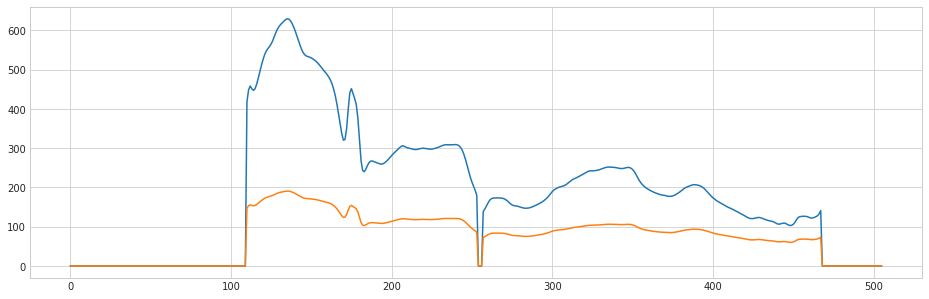

In [24]:
cvf0 = f0stats.convert(src_f0list[0], srcf0stats, tarf0stats)
plt.plot(cvf0)
plt.plot(src_f0list[0])

In [25]:
cvmcep_wGV = gv.postfilter(cv_mceps[0], srcgvstats, cvgvstats=cvgvstats)
cvf0 = f0stats.convert(src_f0list[0], srcf0stats, tarf0stats)
wav = synthesizer.synthesis(cvf0, cvmcep_wGV, src_aplist[0], rmcep=src_mceplist[0])
sf.write(output_path + "te.wav", wav, 16000)

In [26]:
# org-cv distance
with open(output_path + "melcd_org-cv.txt", "w") as outfile:
    outfile.write("adapt8 org-cv mcd.\n")
    for i in range(len(src_mceplist)):
        temp_mcep = src_mceplist[i]
        temp_mcep_0th = temp_mcep[:, 0]
        temp_mcep = temp_mcep[:, 1:]
        
        temp_cv = cv_mceps[i]
        temp_cv_0th = temp_cv[:, 0]
        temp_cv = temp_cv[:, 1:]
        
        _, _, mcd = get_alignment(temp_mcep, temp_mcep_0th, temp_cv, temp_cv_0th, opow=-15, tpow=-15, sd=1)
        outfile.write("{0},{1}\n".format(i, mcd))

# cv-target distance
# read target files and analyze mceps
targets_mceplist = []
targets_list = __same_path + 'adaptation/EJF01/V01/T01/TIMIT/000/*.wav'
for files in sorted(glob.iglob(targets_list, recursive=True)):
    wavf = files
    x, fs = sf.read(wavf)
    x = np.array(x, dtype=np.float)
    x = low_cut_filter(x, fs, cutoff=70)
    assert fs == 16000
    print("extract acoustic featuers: " + wavf)

    f0, sp, ap = feat.analyze(x)
    mcep = feat.mcep()
    targets_mceplist.append(mcep)

with open(output_path + "melcd_cv-target.txt", "w") as outfile:
    outfile.write("adapt8 cv-target mcd.\n")
    
    for i in range(len(src_mceplist)):
        temp_mcep = targets_mceplist[i]
        temp_mcep_0th = temp_mcep[:, 0]
        temp_mcep = temp_mcep[:, 1:]
        
        temp_cv = cv_mceps[i]
        temp_cv_0th = temp_cv[:, 0]
        temp_cv = temp_cv[:, 1:]
        
        _, _, mcd = get_alignment(temp_cv, temp_cv_0th, temp_mcep, temp_mcep_0th, opow=-15, tpow=-15, sd=1)
        outfile.write("{0},{1}\n".format(i, mcd))

# org-target distance
with open(output_path + "melcd_org-target.txt", "w") as outfile:
    outfile.write("adapt8 org-target mcd.\n")
    
    for i in range(len(src_mceplist)):

        temp_mcep = src_mceplist[i]
        temp_mcep_0th = temp_mcep[:, 0]
        temp_mcep = temp_mcep[:, 1:]
        
        temp_mcep2 = targets_mceplist[i]
        temp_mcep2_0th = temp_mcep2[:, 0]
        temp_mcep2 = temp_mcep2[:, 1:]
        
        
        _, _, mcd = get_alignment(temp_mcep, temp_mcep_0th, temp_mcep2, temp_mcep2_0th, opow=-15, tpow=-15, sd=1)
        outfile.write("{0},{1}\n".format(i, mcd))

extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A11.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A14.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A17.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A18.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A19.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A20.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A21.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A22.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A23.wav
extract acoustic featuers: ./utterance/pre-stored0.1.2/adaptation/EJF01/V01/T01/TIMIT/000/A24.wav
extract acoustic fea